In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

In [2]:
# Downloading dataset
!wget https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/car/Leinhardt.csv

--2021-04-26 09:30:17--  https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/car/Leinhardt.csv
Resolving forge.scilab.org (forge.scilab.org)... 109.7.104.55
Connecting to forge.scilab.org (forge.scilab.org)|109.7.104.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3547 (3,5K) [text/csv]
Saving to: ‘Leinhardt.csv.1’

Leinhardt.csv.1     100%[===================>]   3,46K  --.-KB/s    in 0s      

2021-04-26 09:30:18 (14,1 MB/s) - ‘Leinhardt.csv.1’ saved [3547/3547]



In [3]:
# Read dataset - Infant mortality
lein = pd.read_csv('Leinhardt.csv')
# Checking dataframe
print("The shape of the dataset is: {}".format(lein.shape))
lein.head()

The shape of the dataset is: (105, 5)


,Unnamed: 0,income,infant,region,oil
0,Australia,3426,26.7,Asia,no
1,Austria,3350,23.7,Europe,no
2,Belgium,3346,17.0,Europe,no
3,Canada,4751,16.8,Americas,no
4,Denmark,5029,13.5,Europe,no


In [4]:
# Describing dataset
lein.describe()

,income,infant
count,105.000000,101.000000
mean,998.066667,89.047525
std,1416.714294,90.801707
min,50.000000,9.600000
25%,123.000000,26.200000
50%,334.000000,60.600000
75%,1191.000000,129.400000
max,5596.000000,650.000000


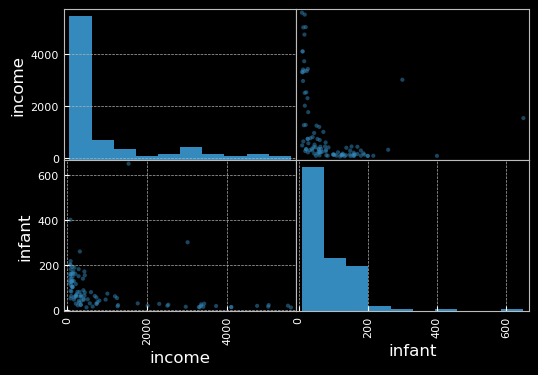

In [5]:
# Dropping NaN
lein = lein.dropna()
# Showing scatter matrix
pd.plotting.scatter_matrix(lein, alpha=0.5)
plt.show()

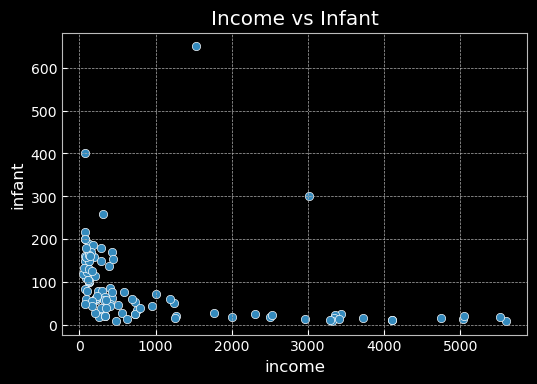

In [6]:
# Plotting infant vs income
sns.scatterplot(lein['income'], lein['infant'], x="Income", y="Infant")
plt.title('Income vs Infant')
plt.show()

Both of these variables are extremely right skewed.

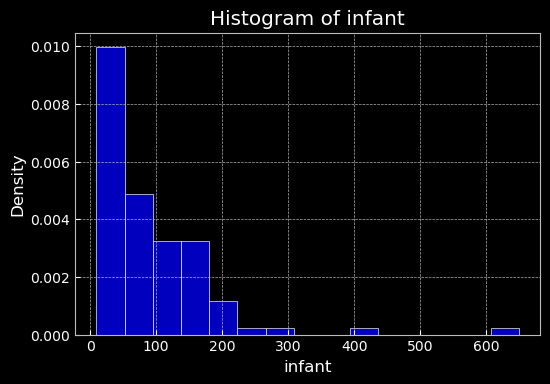

In [7]:
# Plotting the histogram of infant
fig, ax = plt.subplots(1, 1)
sns.histplot(lein['infant'], stat= 'density', bins = 15)
plt.title('Histogram of infant')
plt.show()

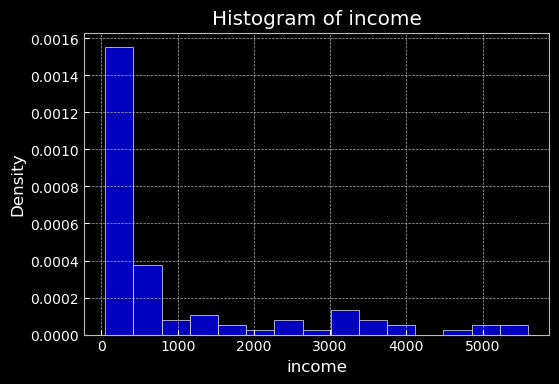

In [8]:
# Plotting the histogram of income
fig, ax = plt.subplots(1, 1)
sns.histplot(lein['income'], stat= 'density', bins = 15)
plt.title('Histogram of income')
plt.show()

Since infant mortality and per capita income are positive and right-skewed quantities, we consider modeling them on the logarithmic scale. A linear model appears much more appropriate on this scale.

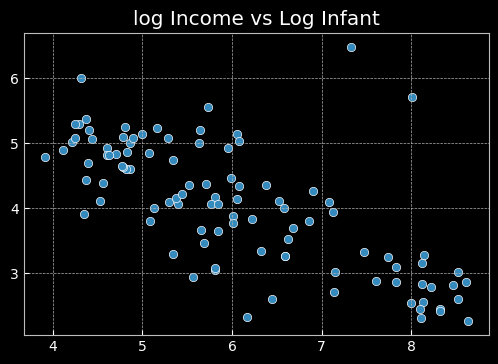

In [9]:
# Changing the domain of the variable
log_income = np.array(np.log(lein['income'])).reshape(-1, 1)
log_infant = np.array(np.log(lein['infant'])).reshape(-1, 1)

# Plotting infant vs income
sns.scatterplot(log_income.reshape(-1,), log_infant.reshape(-1,), x="Log income", y="Log infant")
plt.title('log Income vs Log Infant')
plt.show()

Now it is possible  fitting a line through these data points. 

The reference Bayesian analysis (with a noninformative prior) is: 

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit data with linear regression
reg = LinearRegression().fit(log_income, log_infant)
print("The score of the regression is: {}".format(reg.score(log_income.reshape(-1, 1), log_infant.reshape(-1, 1))))
print("The coefficiens of the regression are: {}".format(reg.coef_))
print("The intercept of the regression is: {}".format(reg.intercept_))


The score of the regression is: 0.50212361972335
The coefficiens of the regression are: [[-0.51179426]]
The intercept of the regression is: [7.1458236]


In [11]:
# Computing the residual standard error
infant_hat = reg.predict(log_income)
RSS = np.sum(np.square(log_infant - infant_hat))
rse = np.sqrt(RSS / (log_infant.shape[0] - 2))
print('The residual standard error of the fit is: {}'.format(rse))
print('The R2 score is: {}'.format(r2_score(log_infant, infant_hat)))

The residual standard error of the fit is: 0.6867078197634027
The R2 score is: 0.50212361972335


In [12]:
import statsmodels.api as sm

N = log_income.shape[0]
p = log_income.shape[1] + 1  # Plus one because LinearRegression adds an intercept term (Only one feature)

X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = log_income

ols = sm.OLS(log_infant, X_with_intercept)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     99.84
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           1.14e-16
Time:                        11:52:23   Log-Likelihood:                -104.34
No. Observations:                 101   AIC:                             212.7
Df Residuals:                      99   BIC:                             217.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1458      0.317     22.575      0.000       6.518       7.774
x1            -0.5118      0.051     -9.992      0.000      -0.613      -0.410
==============================================================================
Omnibus:                       38.668   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.408
Skew:                           1.255   Prob(JB):                     7.93e-29
Kurtosis:                       7.945   Cond. No.                         29.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# Re-vising last problem
print('The of the X variable is: {}'.format(log_income.shape))
print('The of the X variable is: {}'.format(log_infant.shape))

The of the X variable is: (101, 1)
The of the X variable is: (101, 1)


Recall that for a Bayesian linear regression, the model should be (in this particular case)

$y = ax + b + \epsilon \text{ with } \epsilon \sim \mathcal{N}(0, \sigma^2)$

$y \sim \mathcal{N}(\beta_0 + \beta_1 X, \sigma^2)$

$\beta_0 \sim \mathcal{N}(0, 20)$

$\beta_1 \sim \mathcal{N}(0, 20)$

$ \sigma^2 \sim \text{InvGamma}(5/2, (5 * 10)/2)$

In [14]:
with pm.Model() as lr:
    # Definen priors of parameters
    b_0 = pm.Normal('intercept', 0, 20) # Non informative prior
    b_1 = pm.Normal('slope', 0, 20) # Non informative prior
    prior_sz = 5 # Prior sample size
    priot_gss = 10 # Prior guess for variance 
    eps = pm.InverseGamma('epsilon', alpha = prior_sz / 2.0, beta = prior_sz * priot_gss / 2.0)
    
    x_ = pm.Data('features', log_income) # a data container, can be changed

    # Likelihood
    obs = pm.Normal('observation', mu = b_0 + b_1 * x_, sigma = eps, observed = log_infant)

In [15]:
with lr:
    # Use MCMC to sample 10000 samples
    # Sample 2 chains
    trace = pm.sample(10000, tune = 1000)
    # Tune gives a number of samples to reject. These are used to calibrate the sampler. 
    # After the number of samples in tune, the following are considered useful.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, slope, intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### MCMC convergence diagnostic

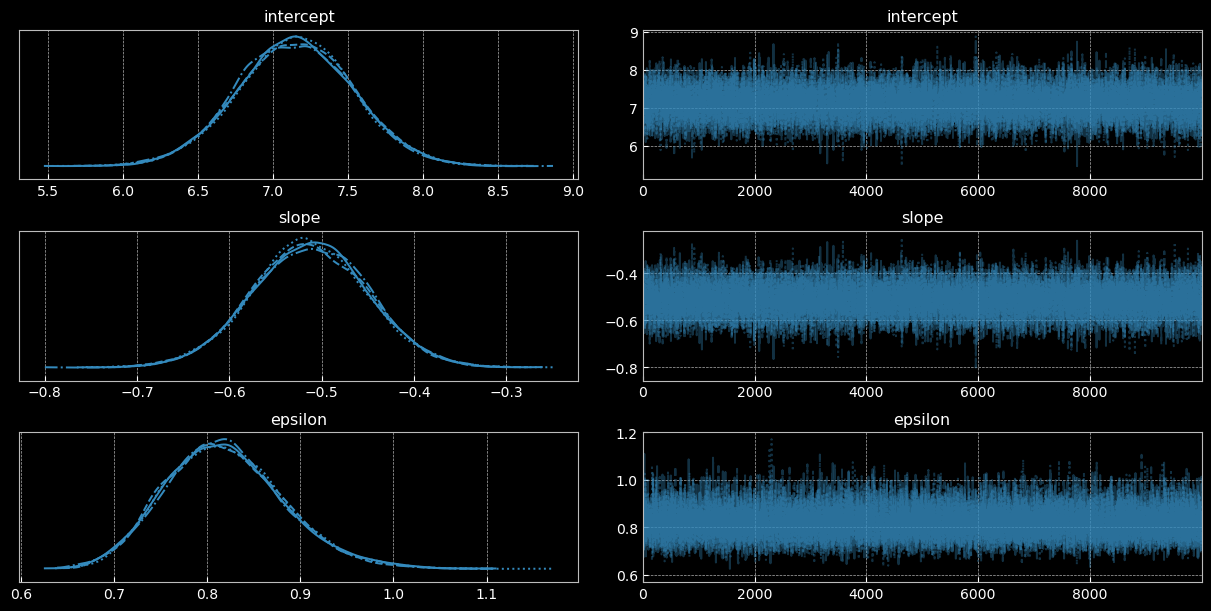

In [16]:
# Plotting posterior distribution of mu
az.plot_trace(trace)
plt.show()

### Gelman-Rubis diagnostic

In [17]:
# Gelman analysis
srf_int = pymc.gelman_rubin(trace['intercept', :].reshape(10000, 4))
srf_slp = pymc.gelman_rubin(trace['slope', :].reshape(10000, 4))
srf_ieps = pymc.gelman_rubin(trace['epsilon', :].reshape(10000, 4))
print('The scale reduction factor for the intercept is: {}'.format(srf_int))
print('The scale reduction factor for the slope is: {}'.format(srf_slp))
print('The scale reduction factor for epsilon is: {}'.format(srf_ieps))

The scale reduction factor for the intercept is: 1.2180405859775842
The scale reduction factor for the slope is: 1.2200063435889483
The scale reduction factor for epsilon is: 1.1520142468441152


All the chains have a Scale reduction factor close to 1. This means that they have converged.

### Autocorrelation

In [18]:
# Compute autocorrelation vector
autocorr_int = stattools.acf(trace['intercept', :])
autocorr_slp = stattools.acf(trace['slope', :])
autocorr_eps = stattools.acf(trace['epsilon', :])
print('The first autocorrelation for the intercept values are: {}'.format(autocorr_int[:5]))
print('The first autocorrelation for the slope values are: {}'.format(autocorr_slp[:5]))
print('The first autocorrelation for epsilon values are: {}\n'.format(autocorr_eps[:5]))

# Computing effective sample size
ess_int = az.ess(trace['intercept', :])
ess_slp = az.ess(trace['slope', :])
ess_eps = az.ess(trace['epsilon', :])
print('The effective sample size of the intercept chain is: {}'.format(ess_int))
print('The effective sample size of the slope chain is: {}'.format(ess_slp))
print('The effective sample size of epsilon chain is: {}'.format(ess_eps))

The first autocorrelation for the intercept values are: [1.         0.46827621 0.22998016 0.11296888 0.0606845 ]
The first autocorrelation for the slope values are: [1.         0.4704422  0.23037852 0.11419294 0.06063217]
The first autocorrelation for epsilon values are: [1.         0.37491521 0.15059168 0.0605029  0.03196506]

The effective sample size of the intercept chain is: 13140.414399644133
The effective sample size of the slope chain is: 13079.208755361795
The effective sample size of epsilon chain is: 17133.05515890731


As the autocorrelation is not very high, the effective sample size grows really high. This means that the amount of information obtained in the chains are considerable, this is why the effective sample size is so big. There are about 40000 samples, this means that the three parameters did very well!

### Summary of the results

In [19]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,7.152,0.386,6.409,7.864,0.003,0.002,13126.0,13039.0,13134.0,14597.0,1.0
slope,-0.513,0.063,-0.629,-0.394,0.001,0.000,13047.0,12895.0,13062.0,14304.0,1.0
epsilon,0.819,0.064,0.701,0.937,0.000,0.000,17617.0,17617.0,17188.0,12715.0,1.0


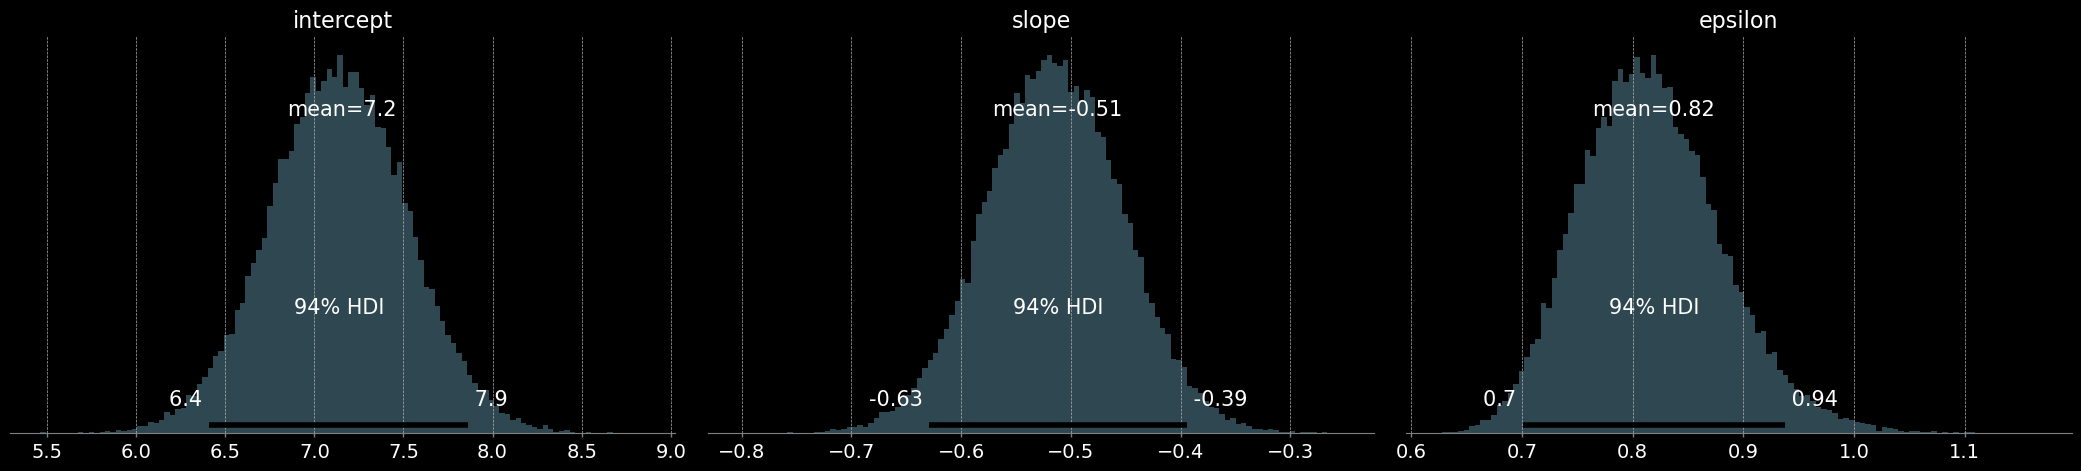

In [20]:
az.plot_posterior(trace, point_estimate = 'mean', kind = 'hist', color= "#87ceeb")
plt.show()

### Checking residuals (Non-bayesian Linear Regression)

Checking residuals (the difference between the response and the model’s prediction for that value) is important with linear models since residuals can reveal violations of the assumptions we made to specify the model. In particular, we are looking for any sign that the model is not linear, normally distributed, or that the observations are not independent (conditional on covariates).

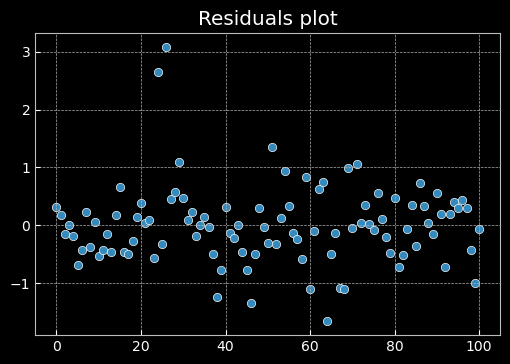

In [21]:
# infant_hat Variable with predictions for normal linear regression 
# Computing residuals
res = (log_infant - infant_hat).reshape(-1,)
# Plotting infant vs income
sns.scatterplot(np.arange(res.shape[0]), res, x="Index", y="Residuals")
plt.title('Residuals plot')
plt.show()

If the data points were not independent from each other, we might see a pattern in this plot. There doesn't appear to be much of a pattern here. So it's at least somewhat reasonable to assume that these data are independent. 

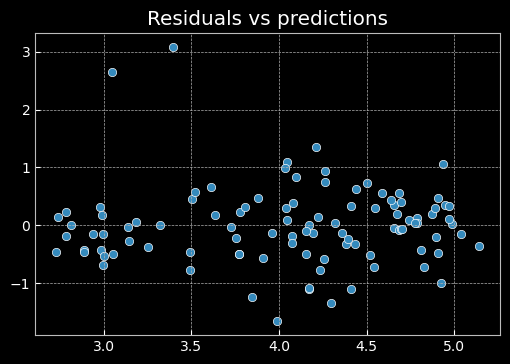

In [22]:
# Plotting infant vs income
sns.scatterplot(infant_hat.reshape(-1), res, x="Predictions", y="Residuals")
plt.title('Residuals vs predictions')
plt.show()

In this plot, we don't want to see any patterns. We want to see essentially randomness. Which is not the case in this plot. First of all, we can see a upward trend, as the values of the prediction from the model get higher, the residuals get higher.

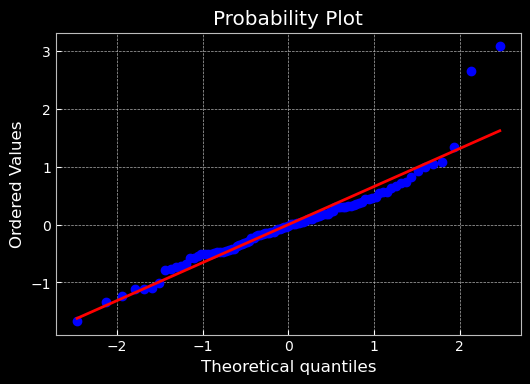

In [23]:
import pylab 
import scipy.stats as stats

# QQ Norm plot
stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

This plot shows the theoretical quantiles or percentiles of an actual normal distribution on the x-axis
with the sample quantiles of the residuals on the y-axis. 

If the residuals actually came from a normal distribution,the points on this plot would essentially follow a straight line. 

In this case, we have a line going up that increases. This indicates that the residuals have a normal distribution.

### Checking residuals (Bayesian regression)

Predictions from Bayesian models come as posterior predictive distributions. So in reality, with the Bayesian model all residuals, or each residual, would have its own distribution. We're going to simplify things a little bit and look at the residuals that come only from predictions based on the posterior means. 

In [24]:
with lr:
    pm.set_data({'features': log_income})
    posterior = pm.sample_posterior_predictive(trace)

In [25]:
y_pred = posterior['observation']
print('The shape of the observations is: {}'.format(y_pred.shape))

The shape of the observations is: (40000, 101, 1)


In [26]:
# Computing Residuals
y_mean = y_pred.mean(axis=0).ravel()
y_std = y_pred.std(axis=0).ravel()
bayes_res = (log_infant.reshape(-1,) - y_mean).reshape(-1,)

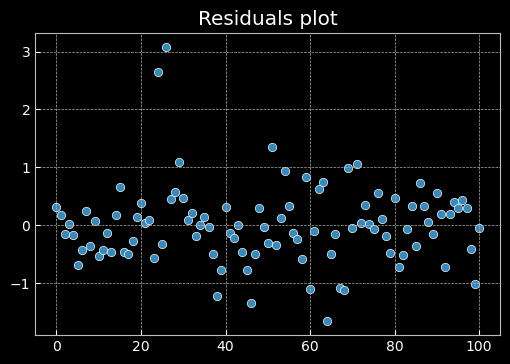

In [27]:
# Plotting residuals
sns.scatterplot(np.arange(res.shape[0]), bayes_res, x="Index", y="Bayes Residuals")
plt.title('Residuals plot')
plt.show()

This plot seems better than vanilla LR as there is more randomness.

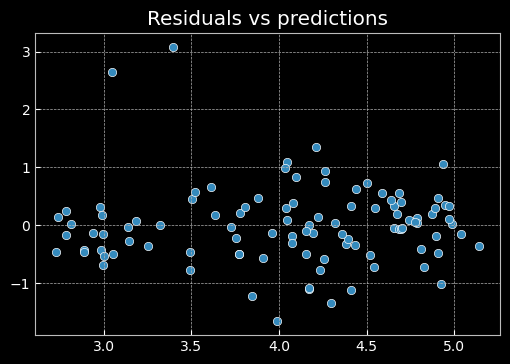

In [28]:
# Plotting infant vs income
sns.scatterplot(infant_hat.reshape(-1), bayes_res, x="Predictions", y="Bayes Residuals")
plt.title('Residuals vs predictions')
plt.show()

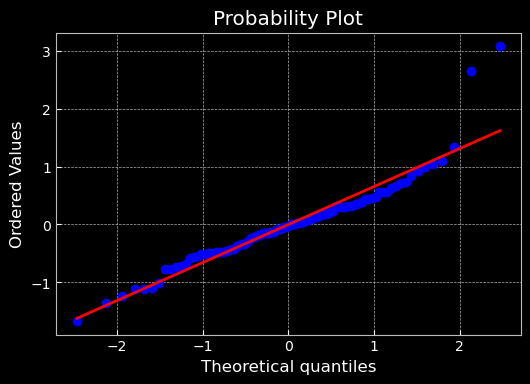

In [29]:
# QQ Norm plot
stats.probplot(bayes_res, dist="norm", plot=pylab)
pylab.show()

Remember, if the residuals are approximately coming from a normal distribution, then this plot would have a linear form between the points. That seems reasonable in this case, except for two outliers.

### Solution for the outliers

One way to deal with these outliers is to use the third variable oil and see if the fits are improved. Additionally, under the presence of outliers it is also a good idea to use a $t$ student as likelihood for this model. The normal likelihood has thin tails (almost all of the probability is concentrated within the first few standard deviations from the mean). This does not accommodate outliers well. Consequently, models with the normal likelihood might be overly-influenced by outliers. Recall that the t distribution is similar to the normal distribution, but it has thicker tails which can accommodate outliers.

The t linear model might look something like this. Notice that the t distribution has three parameters, including a positive “degrees of freedom” parameter. The smaller the degrees of freedom, the heavier the tails of the distribution. We might fix the degrees of freedom to some number, or we can assign it a prior distribution. The new model (using oil) would be:

$y = ax + b + \epsilon \text{ with } \epsilon \sim \mathcal{N}(0, \sigma^2)$

$y \sim t(df,\mu = \beta_0 + \beta_1 X_1, + \beta_2 X_2, \tau)$

$df \sim Exp(1.0)$ # Positive number

$\beta_0 \sim \mathcal{N}(0, 10^{-6})$

$\beta_1 \sim \mathcal{N}(0, 10^{-6})$

$\beta_2 \sim \mathcal{N}(0, 10^{-6})$

$ \tau \sim \text{Gamma}(5/2, (5 * 10)/2)$ # Precision

$ \sigma = \sqrt{\frac{1}{\frac{\tau * df}{df - 2}}} $

### Comparing models

The deviance information criterion (DIC). It essentially calculates the posterior mean of the log-likelihood and adds a penalty for model complexity.